<a href="https://colab.research.google.com/github/josesg998/redesn_2024/blob/main/Notebooks/Ejercicio_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sklearn.metrics
import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Para descomprimir el archivo Neumonia.zip (Si se usa desde Colab)
# Creará dos carpetas:
#     "test"
#     "train"

!unzip "/content/drive/MyDrive/Neumonia.zip" -d "."
drive.flush_and_unmount()

In [6]:
# Generadores
# El parámetro rescale se encarga de escalar los valores del rango [0..255] a [0..1]
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_folderpath = "train/"
test_folderpath = "test/"

# Tamaño de las imágenes a procesar (resized)
alto, ancho = 32, 32
canales = 3 # número de canales

batch_size = 24

print("Train data")
train_generator = train_datagen.flow_from_directory(
    train_folderpath, # directorio de donde cargar las imagenes (train)
    target_size=(alto, ancho),
    batch_size=batch_size,
    class_mode='binary'
    )

n_train = train_generator.samples

print("\n\nTest data")
test_generator = test_datagen.flow_from_directory(
    test_folderpath, # directorio de donde cargar las imagenes (val)
    target_size=(alto, ancho),
    batch_size=batch_size,
    class_mode='binary')

n_test = test_generator.samples

print("\n\nCodificación de clases")
class_dict = train_generator.class_indices # un diccionario donde "key" es el nombre de la clase (nombre del directorio) y "value" es el valor de la clase (0,1, etc.)
print(class_dict)

class_dict_inverse = {}  # Construyo un diccionario donde "key" es el valor de la clase (0, 1, etc.) y "value" es el nombre de la clase (nombre del directorio)
for key in class_dict:
    value = class_dict[key]
    class_dict_inverse[value] = key

Train data
Found 5088 images belonging to 2 classes.


Test data
Found 256 images belonging to 2 classes.


Codificación de clases
{'neumonia': 0, 'normal': 1}


In [7]:
d_in = (alto, ancho, canales)
d_out = 1 # Clasificación binaria

modelo = keras.Sequential([
    keras.layers.Conv2D(8, input_shape=d_in, kernel_size=3, padding='same', activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation= 'tanh'),
    keras.layers.Dense(d_out, activation="sigmoid")
	])

modelo.compile(
  optimizer = keras.optimizers.SGD(learning_rate=0.01),
  loss = 'binary_crossentropy', metrics = ['accuracy']
)

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 8425 (32.91 KB)
Trainable params: 8425 (32.91 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [8]:
history = modelo.fit(train_generator, steps_per_epoch = n_train // batch_size,
                    epochs=5,  validation_data = test_generator  )

Epoch 1/5
212/212 [==============================] - 17s 62ms/step - loss: 0.4609 - accuracy: 0.7936 - val_loss: 0.5741 - val_accuracy: 0.6484
Epoch 2/5
212/212 [==============================] - 15s 70ms/step - loss: 0.3088 - accuracy: 0.8772 - val_loss: 0.2914 - val_accuracy: 0.8945
Epoch 3/5
212/212 [==============================] - 13s 61ms/step - loss: 0.2641 - accuracy: 0.8980 - val_loss: 0.2404 - val_accuracy: 0.8984
Epoch 4/5
212/212 [==============================] - 13s 61ms/step - loss: 0.2216 - accuracy: 0.9163 - val_loss: 0.2835 - val_accuracy: 0.8945
Epoch 5/5
212/212 [==============================] - 13s 63ms/step - loss: 0.2101 - accuracy: 0.9204 - val_loss: 0.2461 - val_accuracy: 0.9141


In [9]:
test_generator.reset()
results = modelo.predict(test_generator)

11/11 [==============================] - 1s 57ms/step


In [10]:
test_file_names = test_generator.filenames
test_labels = test_generator.labels # clase de cada muestra de test

preds = np.zeros(results.shape)
aciertos = 0
umbral = 0.5
for index, pred in enumerate(results):
    if(pred < umbral):
        preds[index] = 0
    else:
        if(pred > (1 - umbral)):
            preds[index] = 1
    if (preds[index] == test_labels[index]):
      aciertos = aciertos + 1
print(f"{aciertos} aciertos en {test_labels.shape[0]} muestras de test.")
print(f"Accuracy: {float(aciertos)/test_labels.shape[0]}")

120 aciertos en 256 muestras de test.
Accuracy: 0.46875


In [11]:
print('TRUE CLASS\tPREDICTED CLASS\tFILENAME')
for i, p in enumerate(preds):
    pred_index = p[0]
    pred_class = class_dict_inverse[pred_index]
    true_class = class_dict_inverse[test_labels[i]]
    file = test_file_names[i]
    print(f'{true_class}\t{pred_class}\t{file}')

TRUE CLASS	PREDICTED CLASS	FILENAME
neumonia	neumonia	neumonia/0128_bacteria.jpg
neumonia	normal	neumonia/0129_bacteria.jpg
neumonia	normal	neumonia/0130_bacteria.jpg
neumonia	normal	neumonia/0131_bacteria.jpg
neumonia	normal	neumonia/0132_bacteria.jpg
neumonia	neumonia	neumonia/0133_bacteria.jpg
neumonia	normal	neumonia/0134_bacteria.jpg
neumonia	neumonia	neumonia/0135_bacteria.jpg
neumonia	normal	neumonia/0136_bacteria.jpg
neumonia	normal	neumonia/0137_bacteria.jpg
neumonia	neumonia	neumonia/0138_bacteria.jpg
neumonia	neumonia	neumonia/0139_bacteria.jpg
neumonia	neumonia	neumonia/0140_bacteria.jpg
neumonia	normal	neumonia/0141_bacteria.jpg
neumonia	neumonia	neumonia/0142_bacteria.jpg
neumonia	neumonia	neumonia/0143_bacteria.jpg
neumonia	neumonia	neumonia/0144_bacteria.jpg
neumonia	normal	neumonia/0145_bacteria.jpg
neumonia	neumonia	neumonia/0146_bacteria.jpg
neumonia	neumonia	neumonia/0147_bacteria.jpg
neumonia	neumonia	neumonia/0148_bacteria.jpg
neumonia	neumonia	neumonia/0149_bacte

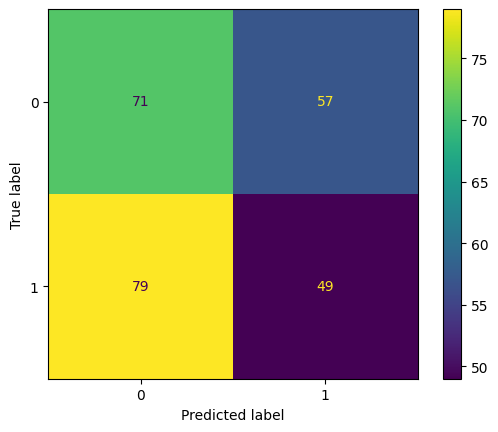

In [12]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(test_labels, preds)